In [49]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics
import math

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

In [2]:
%store -r mc_data

In [3]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        track_classifier = load_model('./models/track_classifier.h5')

In [3]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [4]:
mc_hits = mc_data.values

In [5]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events

In [6]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [7]:
event_threshold = 15840

In [8]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    if (float(x3 - x0)  == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [97]:
#
# Test the NN model by using events not feeded as train 
#

def trackReconstruction(hits_total, index_tree):

    # Variables used for calculating metrics
    total_found = 0
    total = 0
    mean_size = np.zeros(3)

    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    max_hits_gathered = 12

    # Range in which valid hits are look up in the first R-tree
    long_range = 300

    X_classifier = []
    Y_classifier = []

    # For each particle of a given event
    for particle in hits_total:

        # Sometimes there are no PrHits for a given particle, so skip these ones
        if (len(particle[5]) > 1) and (particle[0] != 11) and (particle[0] != -11):

            found_num = 0            
            X_final = {}
            Zone_final = {}
            actual = -1

            # Extract all PrHits
            for i in range(0, len(particle[5])):
                if (actual != particle[8][i]):
                    X_final[particle[8][i]] = []
                    X_final[particle[8][i]].append(particle[5][i])
                    Zone_final[particle[8][i]] = particle[12][i]
                    actual = particle[8][i]
                    found_num += 1
                else:
                    X_final[actual].append(particle[5][i])

            # Check if there are minimum 12 hits found, as for the test, I am only working with complete tracks
            if not 0 in X_final or not 4 in X_final or not 8 in X_final:
                continue

            # List used to iterate over valid height found later on
            valid_y = {}

            # For each station
            for station in range(0,3):

                valid_y[station] = []

                # Compute the layer number based on station
                x0_layer = 0
                if (station == 1):
                    x0_layer = 4
                elif station == 2:
                    x0_layer = 8

                u_layer = x0_layer + 1
                v_layer = x0_layer + 2
                x1_layer = x0_layer + 3

                # Select both the first X position and UP/DOWN based on this
                first_hit = X_final[x0_layer][0]
                zone = Zone_final[x0_layer]
                
                m = zLays[x0_layer] / first_hit
                n = zLays[x0_layer] - (m * first_hit)

                predicted = np.zeros(3)
                predicted[0] = (zLays[u_layer] - n) / m 
                predicted[1] = (zLays[v_layer] - n) / m 
                predicted[2] = (zLays[x1_layer] - n) / m 

                mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)

                # Recolect all nearest hits from each layer using R-trees based on the X-position of the mean predicted
                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, x1_layer, x1_layer, zone, zone), objects='raw'))
                found_layer3 = sorted(found, key=lambda x: np.abs(x[0]- mean_predicted))[:max_hits_gathered]
                arr_layer3 = np.unique(np.array(found_layer3), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, v_layer, v_layer, zone, zone), objects='raw'))
                found_layer2 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer2 = np.unique(np.array(found_layer2), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, u_layer, u_layer, zone, zone), objects='raw'))
                found_layer1 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer1 = np.unique(np.array(found_layer1), axis=0)

                for h3 in arr_layer3:

                    for h2 in arr_layer2:

                        # Predict height for each hit selected in the V layer
                        pred_h2 = predictHeight(first_hit, h3[0], h2[0], v_layer, x0_layer, x1_layer)

                        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                            continue

                        # And for each hit in the V layer, we look up at hits in the U layer with the same height
                        for h1 in arr_layer1:

                            # Predict height for hit in the U layer
                            pred_h1 = predictHeight(first_hit, h3[0], h1[0], u_layer, x0_layer, x1_layer)
                            if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                                continue

                            if np.abs(pred_h2 - pred_h1) < 26:
                                # Insert into a new R-tree to enable search by height
                                # Store the valid height for later iterate over it
                                
                                valid_y[station].append([first_hit, h1[0], pred_h1, h2[0], pred_h2, h3[0], station, (h1[1],h2[1],h3[1])])

            valid_tracks = []
            for val in valid_y[0]:
                if (len(valid_y[1]) > 0 and len(valid_y[2]) > 0):
                    second_sort = sorted(valid_y[1], key = lambda p: np.abs(p[2] - val[2]))
                    if (np.abs(second_sort[0][2] - val[2]) < 100):
                        third_sort = sorted(valid_y[2], key = lambda p: np.abs(p[2] - second_sort[0][2]))
                        if np.abs(third_sort[0][2] - second_sort[0][2]) < 100:
                            valid_tracks.append([val, second_sort[0], third_sort[0]])

            
            repeated = 0
            len_tracks = len(valid_tracks)
            for track in valid_tracks:
                found = 0
                for station in range(0,3):
                    x0_layer = 0
                    if (station == 1):
                        x0_layer = 4
                    elif station == 2:
                        x0_layer = 8

                    u_layer = x0_layer + 1
                    v_layer = x0_layer + 2
                    x1_layer = x0_layer + 3

                    pos = 0
                    zone = 0
                    if (track[station][2] > 0):
                        zone = 1

                    for id in track[station][7]:
                        if (id in particle[4]):
                            found += 1
                            #index_tree.delete(int(id), (track[station][pos], track[station][pos], x0_layer + pos + 1, x0_layer + pos + 1, zone, zone))
                        pos += 1

                if (found > 7):
                    X_classifier.append(track[0][:6] + track[1][:6] + track[2][:6])
                    Y_classifier.append(1)
                    len_tracks -= 1
                    repeated += 1
                elif found < 6:
                    X_classifier.append(track[0][:6] + track[1][:6] + track[2][:6])
                    Y_classifier.append(0)

            if (repeated > 0):
                total_found += 1

            mean_size[0] += (len_tracks)
            total += 1
    #print("\nMean Total Found: %f" % (total_found/total))
    #print("\nMean Size: %f" % (mean_size[0]/total))
    return X_classifier, Y_classifier, total_found/total, mean_size[0]/total
    

In [98]:
mean = size = done = 0
test_events = events[:300]

X_classifier = []
Y_classifier = []

p = index.Property()
p.dimension = 3
    
for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    # print("Event length %d " % len(particles_test_event))
    idx = {}
    mean_val = size_val = 0
    index_tree = index.Index(properties=p, interleaved=False)
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11):
            for i in range(0,len(hit[5])):
                index_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), [float(hit[5][i]), int(hit[4][i])])

    X, Y, mean_val, size_val = trackReconstruction(particles_test_event, index_tree)
    
    X_classifier += X
    Y_classifier += Y
    mean += mean_val
    size += size_val
    done += 1
    print("Event %d/%d \t Acc: %f Size %f Proportion %f" % (done,len(test_events), mean_val, size_val, Y.count(0)/(len(Y))))
    
print("\nFinal Result:")
print("\t X_Size : %f" % (len(X_classifier)))
print("\t Y_Size: %f" % (len(Y_classifier)))
print("\t Y mean 0 : %f" % (Y_classifier.count(0) / len(Y_classifier)))
print("\t Mean: %f" % (mean/len(test_events)))
print("\t Size: %f" % (size/len(test_events)))

Event 1/300 	 Acc: 0.600000 Size 2.586667 Proportion 0.614634
Event 2/300 	 Acc: 0.525641 Size 5.897436 Proportion 0.832998
Event 3/300 	 Acc: 0.416667 Size 3.462963 Proportion 0.794805
Event 4/300 	 Acc: 0.526882 Size 2.247312 Proportion 0.695341
Event 5/300 	 Acc: 0.481707 Size 6.548780 Proportion 0.843209
Event 6/300 	 Acc: 0.660714 Size 0.714286 Proportion 0.292683
Event 7/300 	 Acc: 0.549020 Size 1.294118 Proportion 0.536082
Event 8/300 	 Acc: 0.564516 Size 3.241935 Proportion 0.730263
Event 9/300 	 Acc: 0.649351 Size 1.194805 Proportion 0.372093
Event 10/300 	 Acc: 0.518987 Size 4.392405 Proportion 0.772358
Event 11/300 	 Acc: 0.583333 Size 0.083333 Proportion 0.000000
Event 12/300 	 Acc: 0.500000 Size 0.483871 Proportion 0.281250
Event 13/300 	 Acc: 0.510638 Size 0.234043 Proportion 0.186047
Event 14/300 	 Acc: 0.657143 Size 0.057143 Proportion 0.000000
Event 15/300 	 Acc: 0.651515 Size 0.803030 Proportion 0.336207
Event 16/300 	 Acc: 0.666667 Size 0.500000 Proportion 0.214286
E

Event 131/300 	 Acc: 0.518519 Size 1.722222 Proportion 0.593496
Event 132/300 	 Acc: 0.589474 Size 1.852632 Proportion 0.520179
Event 133/300 	 Acc: 0.651163 Size 0.186047 Proportion 0.000000
Event 134/300 	 Acc: 0.666667 Size 0.294118 Proportion 0.129032
Event 135/300 	 Acc: 0.750000 Size 0.166667 Proportion 0.166667
Event 136/300 	 Acc: 0.717391 Size 0.347826 Proportion 0.085106
Event 137/300 	 Acc: 0.717391 Size 1.239130 Proportion 0.371429
Event 138/300 	 Acc: 0.607843 Size 0.372549 Proportion 0.200000
Event 139/300 	 Acc: 0.380000 Size 16.353333 Proportion 0.945267
Event 140/300 	 Acc: 0.526316 Size 4.726316 Proportion 0.801636
Event 141/300 	 Acc: 0.416667 Size 7.952381 Proportion 0.873362
Event 142/300 	 Acc: 0.510638 Size 2.414894 Proportion 0.701107
Event 143/300 	 Acc: 0.431579 Size 12.236842 Proportion 0.931189
Event 144/300 	 Acc: 0.509804 Size 3.735294 Proportion 0.767943
Event 145/300 	 Acc: 0.661765 Size 1.132353 Proportion 0.397163
Event 146/300 	 Acc: 0.578313 Size 2.3

Event 259/300 	 Acc: 0.584615 Size 1.953846 Proportion 0.594595
Event 260/300 	 Acc: 0.590909 Size 0.818182 Proportion 0.350000
Event 261/300 	 Acc: 0.400000 Size 0.000000 Proportion 0.000000
Event 262/300 	 Acc: 0.437870 Size 8.337278 Proportion 0.905473
Event 263/300 	 Acc: 0.516667 Size 3.658333 Proportion 0.763975
Event 264/300 	 Acc: 0.539007 Size 5.744681 Proportion 0.814286
Event 265/300 	 Acc: 0.528302 Size 0.981132 Proportion 0.486111
Event 266/300 	 Acc: 0.412429 Size 10.079096 Proportion 0.919683
Event 267/300 	 Acc: 0.739130 Size 0.195652 Proportion 0.034483
Event 268/300 	 Acc: 0.584270 Size 2.382022 Proportion 0.636364
Event 269/300 	 Acc: 0.404878 Size 9.892683 Proportion 0.917808
Event 270/300 	 Acc: 0.470588 Size 2.470588 Proportion 0.665689
Event 271/300 	 Acc: 0.409326 Size 11.740933 Proportion 0.926306
Event 272/300 	 Acc: 0.457143 Size 4.642857 Proportion 0.824891
Event 273/300 	 Acc: 0.467105 Size 10.519737 Proportion 0.906817
Event 274/300 	 Acc: 0.629032 Size 0.

In [99]:
final_X_classifier = []
final_Y_classifier = []

for i in range(0, len(Y_classifier)):
    if final_Y_classifier.count(0)/(len(final_Y_classifier) + 1) < 0.51:
        final_X_classifier.append(X_classifier[i])
        final_Y_classifier.append(Y_classifier[i])
    else:
        if Y_classifier[i] == 1:
            final_X_classifier.append(X_classifier[i])
            final_Y_classifier.append(Y_classifier[i])

In [101]:
track_classifier = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
track_classifier.add(Dense(12, activation='relu', input_dim=18))
track_classifier.add(Dense(8, activation='relu'))
track_classifier.add(Dense(1, activation='sigmoid'))
track_classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
track_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12)                228       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [103]:
X_train, X_test, y_train, y_test = train_test_split(np.array(final_X_classifier), np.array(final_Y_classifier))
print("X Train length: %d" % len(X_train))
print("X Test Length %d" % len(X_test))
print("Y Train length: %d" % len(y_train))
print("Y Test length: %d" % len(y_test))

X Train length: 42333
X Test Length 14112
Y Train length: 42333
Y Test length: 14112


In [110]:
track_classifier.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)

Train on 38099 samples, validate on 4234 samples
Epoch 1/10
38099/38099 [==============================] - 1s 21us/sample - loss: 0.0691 - acc: 0.9819 - val_loss: 0.0510 - val_acc: 0.9889
Epoch 2/10
38099/38099 [==============================] - 1s 21us/sample - loss: 0.0451 - acc: 0.9883 - val_loss: 0.0349 - val_acc: 0.9924
Epoch 3/10
38099/38099 [==============================] - 1s 21us/sample - loss: 0.0367 - acc: 0.9901 - val_loss: 0.0356 - val_acc: 0.9927
Epoch 4/10
38099/38099 [==============================] - 1s 20us/sample - loss: 0.0367 - acc: 0.9899 - val_loss: 0.0348 - val_acc: 0.9917
Epoch 5/10
38099/38099 [==============================] - 1s 21us/sample - loss: 0.0350 - acc: 0.9903 - val_loss: 0.0304 - val_acc: 0.9927
Epoch 6/10
38099/38099 [==============================] - 1s 21us/sample - loss: 0.0365 - acc: 0.9895 - val_loss: 0.0290 - val_acc: 0.9939
Epoch 7/10
38099/38099 [==============================] - 1s 24us/sample - loss: 0.0357 - acc: 0.9908 - val_loss: 0.0

In [111]:
score, acc = track_classifier.evaluate(X_test, y_test, batch_size=25)
print('Test score:', score)
print('Test accuracy:', acc)

14112/14112 [==============================] - 1s 44us/sample - loss: 0.0330 - acc: 0.9907
Test score: 0.0329925201488296
Test accuracy: 0.9907171


In [112]:
predictions = track_classifier.predict(X_test)

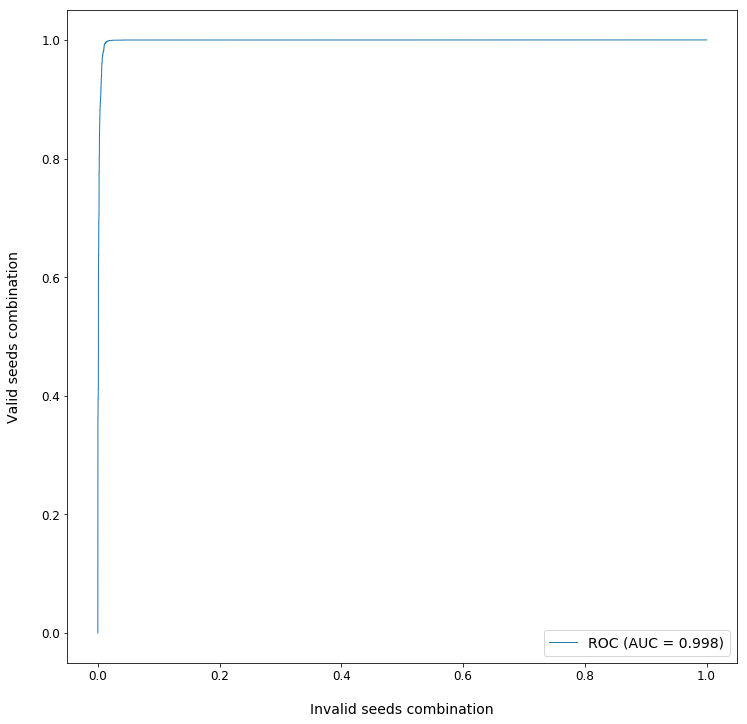

In [119]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(12,12))                                        
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC (AUC = %0.3f)' % (roc_auc))
plt.xlabel('\nInvalid seeds combination', fontsize=14)
plt.ylabel('Valid seeds combination\n', fontsize=14)
plt.legend(loc = 'lower right',prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

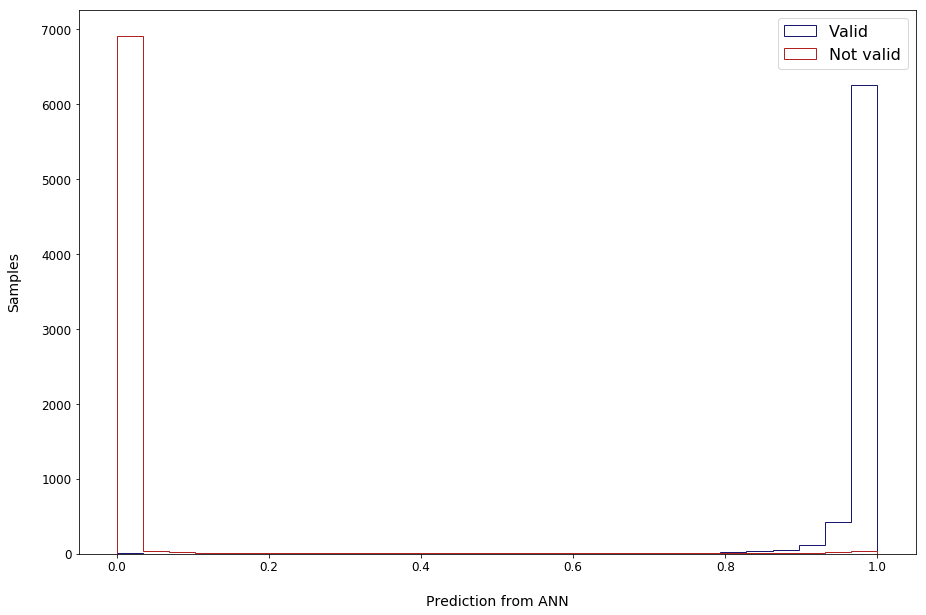

In [120]:
#xgb.plot_importance(booster,grid=True);

fig = plt.figure(figsize=(15,10));
plt.hist(predictions[y_test.reshape(-1).astype(bool)],bins=np.linspace(0,1,30),
         histtype='step',color='midnightblue',label='Valid');
plt.hist(predictions[~(y_test.reshape(-1).astype(bool))],bins=np.linspace(0,1,30),
         histtype='step',color='firebrick',label='Not valid');
# make the plot readable
plt.xlabel('\nPrediction from ANN',fontsize=14);
plt.ylabel('Samples\n',fontsize=14);
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(loc = 'upper right',prop={'size': 16})

In [115]:
track_classifier.save("./models/track_classifier_all_stations_99_>7-<6.h5")